# Data Preprocessing and Library loading:

In [6]:
import json, sys, time, os, copy

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas
import pickle

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score

plt.rcParams['figure.figsize'] = [6.4*2, 4.8*2]
sns.set_theme("paper")
sns.set_style(style="darkgrid")
fullDataset = True

In [7]:
jsonDir = "./jsonFiles"
numpyDir = "./numpyFiles"

fullTestSet = np.load(os.path.join(numpyDir,"fullTestSet.npy"))
errMSE = np.load(os.path.join(numpyDir,"ERROR_MAE_3D_T1.npy"))

with open(os.path.join(jsonDir,"file_list_3D_MAE.json"),"r") as f:
    fileList = json.load(f)

fileList = [x[:-8] for x in fileList]

print("Number of Files: ", len(fileList))

FileNotFoundError: [Errno 2] No such file or directory: './jsonFiles/file_list_3D_MAE.json'

In [3]:
# Flattening Error volume 8x7x7 for RF

errFlat = np.zeros((errMSE.shape[0],errMSE.shape[1]*errMSE.shape[2]*errMSE.shape[3]))

for i in range(errMSE.shape[0]):
    errFlat[i] = errMSE[i,:,:,:].flatten()

print("Pre Flatten {} vs. Flattened {}".format(errMSE.shape,errFlat.shape))

Pre Flatten (31199, 8, 7, 7) vs. Flattened (31199, 392)


In [4]:
# Load in tags and additional meta data:

with open(os.path.join(jsonDir,"./reasons_split.json"),"r") as f: # Tags
    tagDict = json.load(f)

if not fullDataset:
    with open(os.path.join(jsonDir,"biobank_meta_float.json"),"r") as f: # Float meta data from dcm headers
        metaDict = json.load(f)
else:
    with open(os.path.join(jsonDir,"biobank_meta_full_one_hot.json"),"r") as f: # All one hot encoded meta
        metaDict = json.load(f)

with open(os.path.join(jsonDir,"Biobank_Bounding_Boxes.json"),"r") as f: # Bounding box meta data
    bBoxes = json.load(f)

dict_keys(['[SlicePosition_PCS]_0', '[SlicePosition_PCS]_1', '[SlicePosition_PCS]_2', 'Accession Number', 'Echo Train Length', '1', '1_1_0', '2', '3', '4', 'NONE', 'NONE_1_0', 'Algo1', 'WINDOW1', 'Echo Number(s)', 'TI_0', 'TI_1', 'TI_2', 'TI_3', 'TI_4', 'TI_5', 'TI_6', '[TimeAfterStart]_0', '[TimeAfterStart]_1', '[TimeAfterStart]_2', '[TimeAfterStart]_3', '[TimeAfterStart]_4', '[TimeAfterStart]_5', '[TimeAfterStart]_6', 'Samples per Pixel', 'ShMOLLI_192i', 'ShMOLLI_192i LIVER', '[SliceMeasurementDuration]_0', '[SliceMeasurementDuration]_1', '[SliceMeasurementDuration]_2', '[SliceMeasurementDuration]_3', '[SliceMeasurementDuration]_4', '[SliceMeasurementDuration]_5', '[SliceMeasurementDuration]_6', 'Image Position (Patient)_0', 'Image Position (Patient)_1', 'Image Position (Patient)_2', 'Largest Image Pixel Value_0', 'Largest Image Pixel Value_1', 'Largest Image Pixel Value_2', 'Largest Image Pixel Value_3', 'Largest Image Pixel Value_4', 'Largest Image Pixel Value_5', 'Largest Image Pi

In [5]:
# Sort through subj to make sure all meta data present

if fullDataset:
    keys = list(metaDict['eid'].values())
else:
    keys = list(metaDict.keys())

keys = [k for k in keys if k in bBoxes.keys()]
keys = [k for k in keys if k in fileList]

print("Number of Files with complete meta data: ", len(keys))

Number of Files with complete meta data:  31199


In [6]:
###### Find out the keys present in every single case:
if not fullDataset:
    allMetaKeys = []
    instTime = ["1","2","3","4","5","6","7"]
    for k in keys:
        for i in instTime:
            allMetaKeys.extend(list(metaDict[k][i].keys()))

    allMetaKeysSet = set(allMetaKeys)

    keysOI = []
    for k in allMetaKeysSet:
        if allMetaKeys.count(k) == (len(keys)*7):
            keysOI.append(k)
else:
    keysOI = list(metaDict.keys())

print("Meta values to use: \n\n", keysOI)

Meta values to use: 

 ['[SlicePosition_PCS]_0', '[SlicePosition_PCS]_1', '[SlicePosition_PCS]_2', 'Accession Number', 'Echo Train Length', '1', '1_1_0', '2', '3', '4', 'NONE', 'NONE_1_0', 'Algo1', 'WINDOW1', 'Echo Number(s)', 'TI_0', 'TI_1', 'TI_2', 'TI_3', 'TI_4', 'TI_5', 'TI_6', '[TimeAfterStart]_0', '[TimeAfterStart]_1', '[TimeAfterStart]_2', '[TimeAfterStart]_3', '[TimeAfterStart]_4', '[TimeAfterStart]_5', '[TimeAfterStart]_6', 'Samples per Pixel', 'ShMOLLI_192i', 'ShMOLLI_192i LIVER', '[SliceMeasurementDuration]_0', '[SliceMeasurementDuration]_1', '[SliceMeasurementDuration]_2', '[SliceMeasurementDuration]_3', '[SliceMeasurementDuration]_4', '[SliceMeasurementDuration]_5', '[SliceMeasurementDuration]_6', 'Image Position (Patient)_0', 'Image Position (Patient)_1', 'Image Position (Patient)_2', 'Largest Image Pixel Value_0', 'Largest Image Pixel Value_1', 'Largest Image Pixel Value_2', 'Largest Image Pixel Value_3', 'Largest Image Pixel Value_4', 'Largest Image Pixel Value_5', 'Lar

In [7]:

# Create dataset (full one hot):
if fullDataset:
    subjLength = len(keys)
    dataLength = len(keysOI)
    bBoxesLength = 16
    errLength = errFlat.shape[1]

    ownDataset = np.zeros((subjLength,dataLength + bBoxesLength + errLength))

    k0 = list(tagDict.keys())[0]
    tags = np.zeros((subjLength,len(tagDict[k0])))

    for i,k in enumerate(keys):
        sys.stdout.write("\r[{}/{}]".format(i,len(keys)))
        metaList = []
        for kOI in keysOI:
            metaList.append(metaDict[kOI][str(i)])

        try:
            metaList.extend(bBoxes[k]["Body"])
        except KeyError as e:
            metaList.extend([0,0,0,0])

        try:
            metaList.extend(bBoxes[k]["Liver"])
        except KeyError as e:
            metaList.extend([0,0,0,0])

        try:
            metaList.extend(bBoxes[k]["Lungs"])
        except KeyError as e:
            metaList.extend([0,0,0,0])

        try:
            metaList.extend(bBoxes[k]["Heart"])
        except KeyError as e:
            metaList.extend([0,0,0,0])

        charArr = np.char.find(fileList,k)
        charIdx = np.argwhere(charArr == 0)[0,0]
        
        assert(type(charIdx) == np.int64)
        errMeta = list(errFlat[charIdx,:])

        metaList.extend(errMeta)

        ownDataset[i,:] = np.array(metaList)
        if k in tagDict.keys():
            tags[i] = np.array(tagDict[k])

    ownDataset = (ownDataset,tags)

    print("\n Meta Data for Subj0: {} \n Tag for Subj0: {}".format(ownDataset[0][0][:10],ownDataset[1][0]))

# Create dataset (float only):
else:
    subjLength = len(keys)
    dataLength = len(keysOI)*len(instTime)
    print("Data Length: {}\n".format(dataLength))
    bBoxesLength = 16
    errLength = errFlat.shape[1]

    ownDataset = np.zeros((subjLength,dataLength + bBoxesLength + errLength))

    k0 = list(tagDict.keys())[0]
    tags = np.zeros((subjLength,len(tagDict[k0])))

    for i,k in enumerate(keys):
        sys.stdout.write("\r[{}/{}]".format(i,len(keys)))
        metaList = []
        for kOI in keysOI:
            for inst in instTime:
                metaList.append(metaDict[k][inst][kOI])
        try:
            metaList.extend(bBoxes[k]["Body"])
        except KeyError as e:
            metaList.extend([0,0,0,0])

        try:
            metaList.extend(bBoxes[k]["Liver"])
        except KeyError as e:
            metaList.extend([0,0,0,0])

        try:
            metaList.extend(bBoxes[k]["Lungs"])
        except KeyError as e:
            metaList.extend([0,0,0,0])

        try:
            metaList.extend(bBoxes[k]["Heart"])
        except KeyError as e:
            metaList.extend([0,0,0,0])

        charArr = np.char.find(fileList,k)
        charIdx = np.argwhere(charArr == 0)[0,0]
        
        assert(type(charIdx) == np.int64)
        errMeta = list(errFlat[charIdx,:])

        metaList.extend(errMeta)

        ownDataset[i,:] = np.array(metaList)
        if k in tagDict.keys():
            tags[i] = np.array(tagDict[k])

    ownDataset = (ownDataset,tags)

    print("\n Meta Data for Subj0: {} \n Tag for Subj0: {}".format(ownDataset[0][0][:10],ownDataset[1][0]))

[31198/31199]
 Meta Data for Subj0: [-221.11607361 -140.75375366   -0.25          0.            1.
    1.            0.            0.            0.            0.        ] 
 Tag for Subj0: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [8]:
print("Header Meta Data: {} \nBounding Box Meta Data: {} \nImage Recon Errors: {} \n".format(dataLength,bBoxesLength,errLength))

Header Meta Data: 286 
Bounding Box Meta Data: 16 
Image Recon Errors: 392 



# Train Random Forests:

## All Data:

In [9]:
# Hyperparameters:

testSize = 0.5
n_estimators = 100
max_depth = 10
tagNames = ['Artifacts', 'badsequence', 'Field_artefacts', 'highiron-lowt1', 'lookuptable-rip', 'm50pcfail', 'Other_Unlisted', 'pdff35', 'Rainbow', 'Segmentation_fail', 'Wrong_location', 'zeroct1']
numAvgs = np.arange(0,20,1)


In [10]:
x0, y0 = ownDataset

metricsDict = {}
clfDict = {}

topAUC = {}
avgAUC = {}
for name in tagNames:
    topAUC[name] = 0.0
    metricsDict[name] = {}
    avgAUC[name] = []
    clfDict[name] = {}

cnt = 0
for idx,name in enumerate(tagNames):

    y = y0[:,idx]
    X = x0[:,:]

    rskf = RepeatedStratifiedKFold(random_state=42)

    for train_index, test_index in rskf.split(X, y):
        sys.stdout.write("\r[{}/{}]".format(cnt,5*10*len(tagNames)))

        clf = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,verbose=False,n_jobs=-1)

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        probs = clf.predict_proba(X_test)

        fpr,tpr,thresh = roc_curve(y_test,probs[:,1])
        auc_score = roc_auc_score(y_test,probs[:,1])

        avgAUC[name].append(auc_score)

        if topAUC[name] < auc_score:
            topAUC[name] = auc_score

            clfDict[name]["Classifier"] = clf
            clfDict[name]["X_train"] = X_train
            clfDict[name]["y_train"] = y_train
            clfDict[name]["X_test"] = X_test
            clfDict[name]["y_test"] = y_test

            metricsDict[name]["AUC"] = auc_score
            metricsDict[name]["FPR"] = fpr
            metricsDict[name]["TPR"] = tpr

        cnt +=1

[599/600]

In [11]:
# Format for Seaborn

modelsArr = []
fprArr = []
tprArr = []

for name in tagNames:
    auc_score = metricsDict[name]["AUC"]
    fpr = metricsDict[name]["FPR"]
    tpr = metricsDict[name]["TPR"]

    event = ["{}, AUC = {:.3f}".format(name,auc_score)]*(fpr.shape[0])

    modelsArr.extend(event)
    fprArr.extend(fpr)
    tprArr.extend(tpr)

event = np.array(modelsArr)
fpr = np.array(fprArr)
tpr = np.array(tprArr)

df = pandas.DataFrame({"Model":event,"false positive rate":fpr,"true positive rate":tpr})
df2 = pandas.DataFrame(avgAUC)
print(df2.describe())

print("#"*50)

tempDict = {"Name":tagNames,"Max AUC":[metricsDict[name]["AUC"] for name in tagNames],"Avg AUC":[np.mean(avgAUC[name]) for name in tagNames]}

df3 = pandas.DataFrame(tempDict)
print(df3)

       Artifacts  badsequence  Field_artefacts  highiron-lowt1  \
count  50.000000    50.000000        50.000000       50.000000   
mean    0.752132     0.998598         0.852736        0.824066   
std     0.028509     0.000408         0.019914        0.032455   
min     0.674784     0.997430         0.806765        0.746570   
25%     0.735034     0.998411         0.835519        0.797168   
50%     0.752346     0.998690         0.851024        0.826312   
75%     0.772372     0.998894         0.868495        0.845068   
max     0.807600     0.999236         0.893833        0.889362   

       lookuptable-rip  m50pcfail  Other_Unlisted     pdff35    Rainbow  \
count        50.000000  50.000000       50.000000  50.000000  50.000000   
mean          0.836027   0.924224        0.897238   0.841791   0.915924   
std           0.058315   0.016701        0.015839   0.042565   0.012439   
min           0.669596   0.876753        0.855274   0.746716   0.890965   
25%           0.805870   0.916

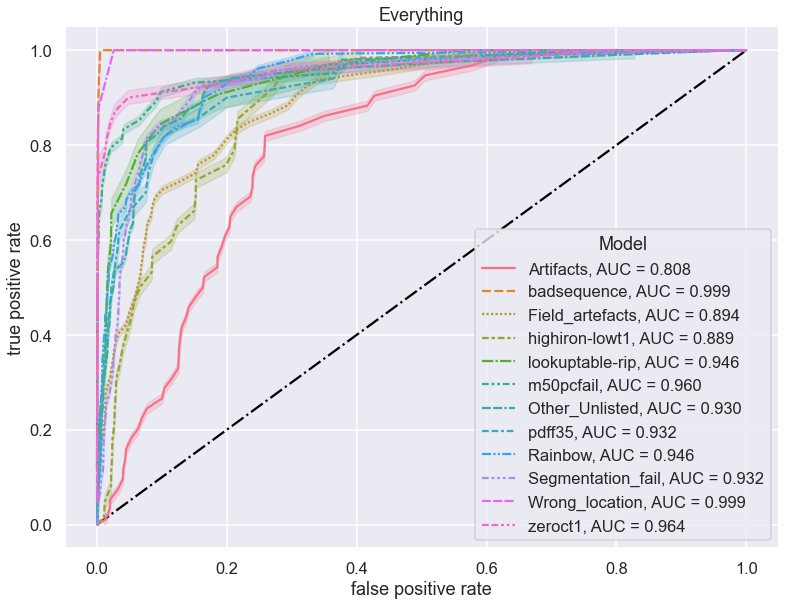

In [19]:
# Plot the ROC curves for each Class (One Vs Rest)
sns.set_theme(context="talk")
plt.figure()
plt.title("Everything")
sns.lineplot(x=[0,1],y=[0,1],linestyle="-.",color='black')
sns.lineplot(data=df,x="false positive rate",y="true positive rate",hue="Model",style="Model")
plt.show()

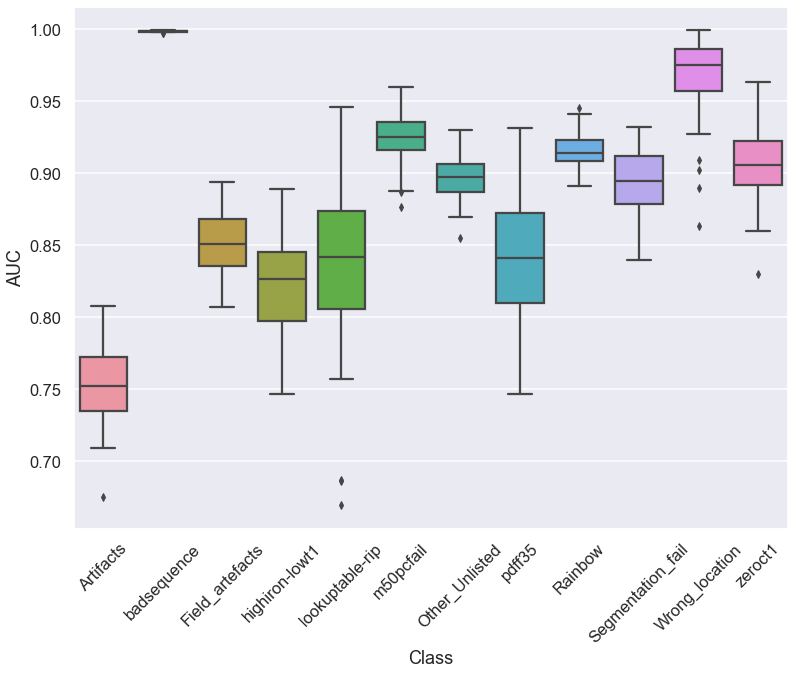

In [20]:
dictBox = {"Class":[],"AUC":[]}
for k in avgAUC.keys():
    for itm in avgAUC[k]:
        dictBox["Class"].append(k)
        dictBox["AUC"].append(itm)

dfBox = pandas.DataFrame(dictBox)

sns.boxplot(x="Class",y="AUC",data=dfBox)
plt.xticks(rotation=45)
plt.show()

In [21]:
# Save Models
saveDir = "./models/Random Forests/All_Meta/"

if not os.path.isdir(saveDir):
    os.mkdir(saveDir)

for name in tagNames:
    if not os.path.isdir(os.path.join(saveDir,name)):
        os.mkdir(os.path.join(saveDir,name))
    pickle.dump(clfDict[name], open(os.path.join(saveDir,name,"classifier.sav"),'wb'))

df2.to_excel(os.path.join(saveDir,"metrics.xlsx"))
df2.to_json(os.path.join(saveDir,"metrics.json"))

df.to_excel(os.path.join(saveDir,"roc_values.xlsx"))
df.to_json(os.path.join(saveDir,"roc_values.json"))

## Meta + Bboxes:

In [22]:
x0, y0 = ownDataset

metricsDict = {}
clfDict = {}

topAUC = {}
avgAUC = {}
for name in tagNames:
    topAUC[name] = 0.0
    metricsDict[name] = {}
    avgAUC[name] = []
    clfDict[name] = {}

cnt = 0
for idx,name in enumerate(tagNames):

    y = y0[:,idx]
    X = x0[:,:-errLength]

    rskf = RepeatedStratifiedKFold(random_state=42)

    for train_index, test_index in rskf.split(X, y):
        sys.stdout.write("\r[{}/{}]".format(cnt,5*10*len(tagNames)))

        clf = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,verbose=False,n_jobs=-1)

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        probs = clf.predict_proba(X_test)

        fpr,tpr,thresh = roc_curve(y_test,probs[:,1])
        auc_score = roc_auc_score(y_test,probs[:,1])

        avgAUC[name].append(auc_score)

        if topAUC[name] < auc_score:
            topAUC[name] = auc_score

            clfDict[name]["Classifier"] = clf
            clfDict[name]["X_train"] = X_train
            clfDict[name]["y_train"] = y_train
            clfDict[name]["X_test"] = X_test
            clfDict[name]["y_test"] = y_test

            metricsDict[name]["AUC"] = auc_score
            metricsDict[name]["FPR"] = fpr
            metricsDict[name]["TPR"] = tpr

        cnt +=1

[599/600]

In [38]:
# Format for Seaborn

modelsArr = []
fprArr = []
tprArr = []

for name in tagNames:
    auc_score = metricsDict[name]["AUC"]
    fpr = metricsDict[name]["FPR"]
    tpr = metricsDict[name]["TPR"]

    event = ["{}, AUC = {:.3f}".format(name,auc_score)]*(fpr.shape[0])

    modelsArr.extend(event)
    fprArr.extend(fpr)
    tprArr.extend(tpr)

event = np.array(modelsArr)
fpr = np.array(fprArr)
tpr = np.array(tprArr)

df = pandas.DataFrame({"Model":event,"false positive rate":fpr,"true positive rate":tpr})
df2 = pandas.DataFrame(avgAUC)
print(df2.describe())

print("#"*50)

tempDict = {"Name":tagNames,"Max AUC":[metricsDict[name]["AUC"] for name in tagNames],"Avg AUC":[np.mean(avgAUC[name]) for name in tagNames]}

df3 = pandas.DataFrame(tempDict)
print(df3)

       Artifacts  badsequence  Field_artefacts  highiron-lowt1  \
count  50.000000    50.000000        50.000000       50.000000   
mean    0.760446     0.998665         0.866369        0.852017   
std     0.025813     0.000391         0.018104        0.029972   
min     0.710371     0.997708         0.829367        0.782148   
25%     0.737200     0.998389         0.852121        0.836524   
50%     0.760655     0.998765         0.864881        0.855070   
75%     0.782088     0.998914         0.879051        0.869214   
max     0.808563     0.999287         0.900934        0.912510   

       lookuptable-rip  m50pcfail  Other_Unlisted     pdff35    Rainbow  \
count        50.000000  50.000000       50.000000  50.000000  50.000000   
mean          0.858399   0.927700        0.899944   0.857793   0.919509   
std           0.044634   0.014685        0.016370   0.042026   0.012721   
min           0.749890   0.887790        0.858314   0.778578   0.890868   
25%           0.833452   0.917

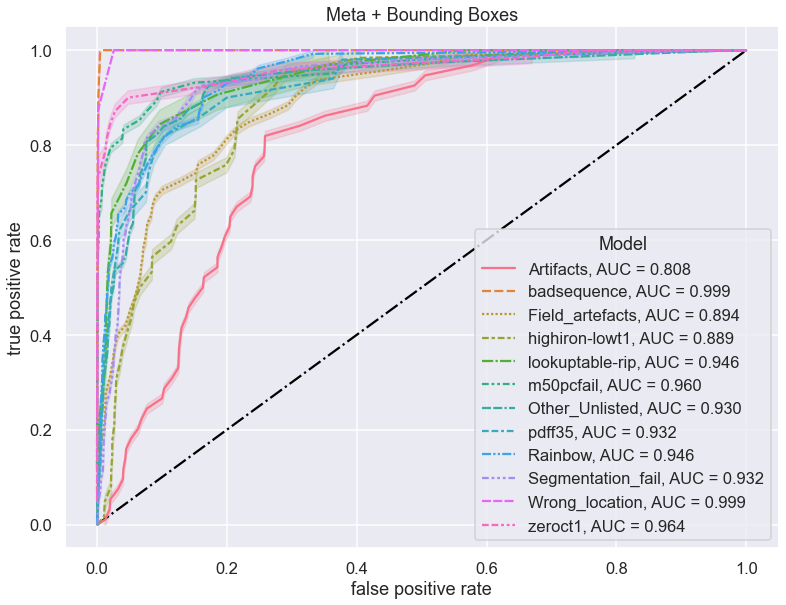

In [23]:
# Plot the ROC curves for each Class (One Vs Rest)
sns.set_theme(context="talk")

plt.figure()
plt.title("Meta + Bounding Boxes")
sns.lineplot(x=[0,1],y=[0,1],linestyle="-.",color='black')
sns.lineplot(data=df,x="false positive rate",y="true positive rate",hue="Model",style="Model")
plt.show()

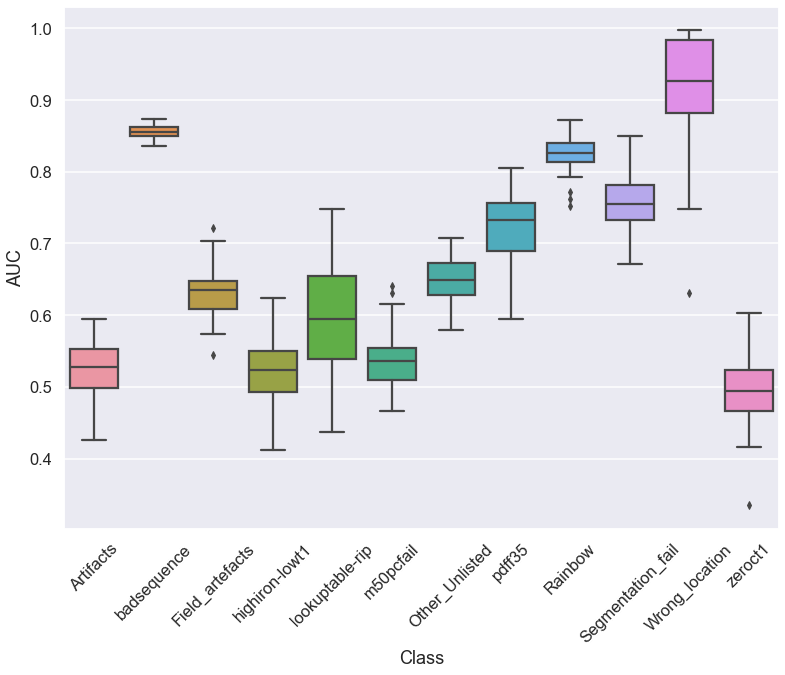

In [24]:
dictBox = {"Class":[],"AUC":[]}
for k in avgAUC.keys():
    for itm in avgAUC[k]:
        dictBox["Class"].append(k)
        dictBox["AUC"].append(itm)

dfBox = pandas.DataFrame(dictBox)

sns.boxplot(x="Class",y="AUC",data=dfBox)
plt.xticks(rotation=45)
plt.show()

In [25]:
# Save Models
saveDir = "./models/Random Forests/Meta_BBoxes/"

if not os.path.isdir(saveDir):
    os.mkdir(saveDir)

for name in tagNames:
    if not os.path.isdir(os.path.join(saveDir,name)):
        os.mkdir(os.path.join(saveDir,name))
    pickle.dump(clfDict[name], open(os.path.join(saveDir,name,"classifier.sav"),'wb'))

df2.to_excel(os.path.join(saveDir,"metrics.xlsx"))
df2.to_json(os.path.join(saveDir,"metrics.json"))

df.to_excel(os.path.join(saveDir,"roc_values.xlsx"))
df.to_json(os.path.join(saveDir,"roc_values.json"))

## Meta Only:

In [26]:
x0, y0 = ownDataset

metricsDict = {}
clfDict = {}

topAUC = {}
avgAUC = {}
for name in tagNames:
    topAUC[name] = 0.0
    metricsDict[name] = {}
    avgAUC[name] = []
    clfDict[name] = {}

cnt = 0
for idx,name in enumerate(tagNames):

    y = y0[:,idx]
    X = x0[:,:-(bBoxesLength+errLength)]

    rskf = RepeatedStratifiedKFold(random_state=42)

    for train_index, test_index in rskf.split(X, y):
        sys.stdout.write("\r[{}/{}]".format(cnt,5*10*len(tagNames)))

        clf = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,verbose=False,n_jobs=-1)

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        probs = clf.predict_proba(X_test)

        fpr,tpr,thresh = roc_curve(y_test,probs[:,1])
        auc_score = roc_auc_score(y_test,probs[:,1])

        avgAUC[name].append(auc_score)

        if topAUC[name] < auc_score:
            topAUC[name] = auc_score

            clfDict[name]["Classifier"] = clf
            clfDict[name]["X_train"] = X_train
            clfDict[name]["y_train"] = y_train
            clfDict[name]["X_test"] = X_test
            clfDict[name]["y_test"] = y_test

            metricsDict[name]["AUC"] = auc_score
            metricsDict[name]["FPR"] = fpr
            metricsDict[name]["TPR"] = tpr

        cnt +=1

[599/600]

In [39]:
# Format for Seaborn

modelsArr = []
fprArr = []
tprArr = []

for name in tagNames:
    auc_score = metricsDict[name]["AUC"]
    fpr = metricsDict[name]["FPR"]
    tpr = metricsDict[name]["TPR"]

    event = ["{}, AUC = {:.3f}".format(name,auc_score)]*(fpr.shape[0])

    modelsArr.extend(event)
    fprArr.extend(fpr)
    tprArr.extend(tpr)

event = np.array(modelsArr)
fpr = np.array(fprArr)
tpr = np.array(tprArr)

df = pandas.DataFrame({"Model":event,"false positive rate":fpr,"true positive rate":tpr})
df2 = pandas.DataFrame(avgAUC)
print(df2.describe())

print("#"*50)

tempDict = {"Name":tagNames,"Max AUC":[metricsDict[name]["AUC"] for name in tagNames],"Avg AUC":[np.mean(avgAUC[name]) for name in tagNames]}

df3 = pandas.DataFrame(tempDict)
print(df3)

       Artifacts  badsequence  Field_artefacts  highiron-lowt1  \
count  50.000000    50.000000        50.000000       50.000000   
mean    0.760446     0.998665         0.866369        0.852017   
std     0.025813     0.000391         0.018104        0.029972   
min     0.710371     0.997708         0.829367        0.782148   
25%     0.737200     0.998389         0.852121        0.836524   
50%     0.760655     0.998765         0.864881        0.855070   
75%     0.782088     0.998914         0.879051        0.869214   
max     0.808563     0.999287         0.900934        0.912510   

       lookuptable-rip  m50pcfail  Other_Unlisted     pdff35    Rainbow  \
count        50.000000  50.000000       50.000000  50.000000  50.000000   
mean          0.858399   0.927700        0.899944   0.857793   0.919509   
std           0.044634   0.014685        0.016370   0.042026   0.012721   
min           0.749890   0.887790        0.858314   0.778578   0.890868   
25%           0.833452   0.917

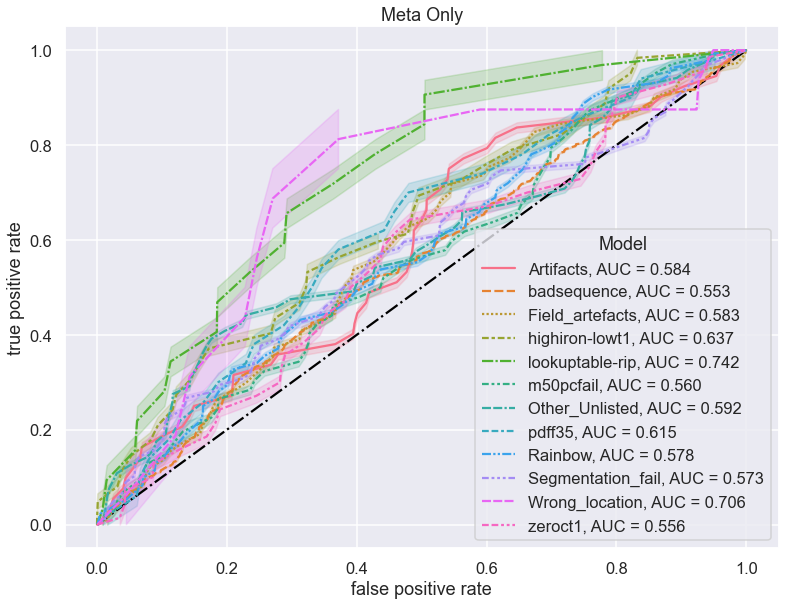

In [29]:
# Plot the ROC curves for each Class (One Vs Rest)
sns.set_theme(context="talk")
plt.figure()
plt.title("Meta Only")
sns.lineplot(x=[0,1],y=[0,1],linestyle="-.",color='black')
sns.lineplot(data=df,x="false positive rate",y="true positive rate",hue="Model",style="Model")
plt.show()

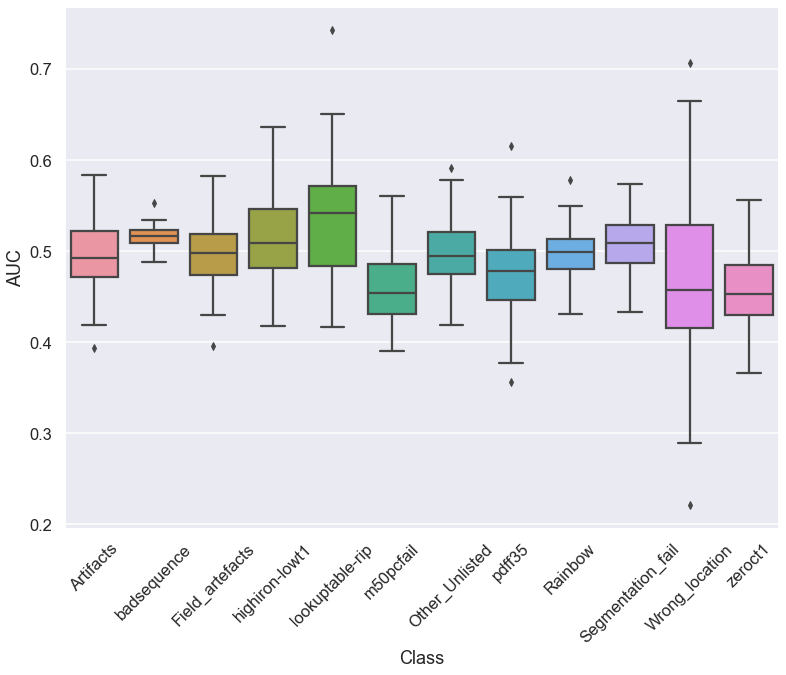

In [30]:
dictBox = {"Class":[],"AUC":[]}
for k in avgAUC.keys():
    for itm in avgAUC[k]:
        dictBox["Class"].append(k)
        dictBox["AUC"].append(itm)

dfBox = pandas.DataFrame(dictBox)

sns.boxplot(x="Class",y="AUC",data=dfBox)
plt.xticks(rotation=45)
plt.show()

In [31]:
# Save Models
saveDir = "./models/Random Forests/Meta_Only/"

if not os.path.isdir(saveDir):
    os.mkdir(saveDir)

for name in tagNames:
    if not os.path.isdir(os.path.join(saveDir,name)):
        os.mkdir(os.path.join(saveDir,name))
    pickle.dump(clfDict[name], open(os.path.join(saveDir,name,"classifier.sav"),'wb'))

df2.to_excel(os.path.join(saveDir,"metrics.xlsx"))
df2.to_json(os.path.join(saveDir,"metrics.json"))

df.to_excel(os.path.join(saveDir,"roc_values.xlsx"))
df.to_json(os.path.join(saveDir,"roc_values.json"))

## Error Only: 

In [32]:
x0, y0 = ownDataset

metricsDict = {}
clfDict = {}

topAUC = {}
avgAUC = {}
for name in tagNames:
    topAUC[name] = 0.0
    metricsDict[name] = {}
    avgAUC[name] = []
    clfDict[name] = {}

cnt = 0
for idx,name in enumerate(tagNames):

    y = y0[:,idx]
    X = x0[:,-errLength:]

    rskf = RepeatedStratifiedKFold(random_state=42)

    for train_index, test_index in rskf.split(X, y):
        sys.stdout.write("\r[{}/{}]".format(cnt,5*10*len(tagNames)))

        clf = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,verbose=False,n_jobs=-1)

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        probs = clf.predict_proba(X_test)

        fpr,tpr,thresh = roc_curve(y_test,probs[:,1])
        auc_score = roc_auc_score(y_test,probs[:,1])

        avgAUC[name].append(auc_score)

        if topAUC[name] < auc_score:
            topAUC[name] = auc_score

            clfDict[name]["Classifier"] = clf
            clfDict[name]["X_train"] = X_train
            clfDict[name]["y_train"] = y_train
            clfDict[name]["X_test"] = X_test
            clfDict[name]["y_test"] = y_test

            metricsDict[name]["AUC"] = auc_score
            metricsDict[name]["FPR"] = fpr
            metricsDict[name]["TPR"] = tpr

        cnt +=1

[599/600]

In [33]:
# Format for Seaborn

modelsArr = []
fprArr = []
tprArr = []

for name in tagNames:
    auc_score = metricsDict[name]["AUC"]
    fpr = metricsDict[name]["FPR"]
    tpr = metricsDict[name]["TPR"]

    event = ["{}, AUC = {:.3f}".format(name,auc_score)]*(fpr.shape[0])

    modelsArr.extend(event)
    fprArr.extend(fpr)
    tprArr.extend(tpr)

event = np.array(modelsArr)
fpr = np.array(fprArr)
tpr = np.array(tprArr)

df = pandas.DataFrame({"Model":event,"false positive rate":fpr,"true positive rate":tpr})
df2 = pandas.DataFrame(avgAUC)
print(df2.describe())

print("#"*50)

tempDict = {"Name":tagNames,"Max AUC":[metricsDict[name]["AUC"] for name in tagNames],"Avg AUC":[np.mean(avgAUC[name]) for name in tagNames]}

df3 = pandas.DataFrame(tempDict)
print(df3)

       Artifacts  badsequence  Field_artefacts  highiron-lowt1  \
count  50.000000    50.000000        50.000000       50.000000   
mean    0.754659     0.998156         0.868820        0.854430   
std     0.026426     0.000442         0.018953        0.034439   
min     0.698400     0.997069         0.825376        0.771658   
25%     0.736163     0.997869         0.856229        0.830926   
50%     0.753654     0.998188         0.870434        0.854971   
75%     0.774208     0.998466         0.882400        0.875690   
max     0.804439     0.998894         0.903667        0.918774   

       lookuptable-rip  m50pcfail  Other_Unlisted     pdff35    Rainbow  \
count        50.000000  50.000000       50.000000  50.000000  50.000000   
mean          0.856350   0.922350        0.894071   0.855517   0.916158   
std           0.042369   0.015770        0.016343   0.039858   0.014479   
min           0.738638   0.888112        0.854837   0.734751   0.886412   
25%           0.834660   0.912

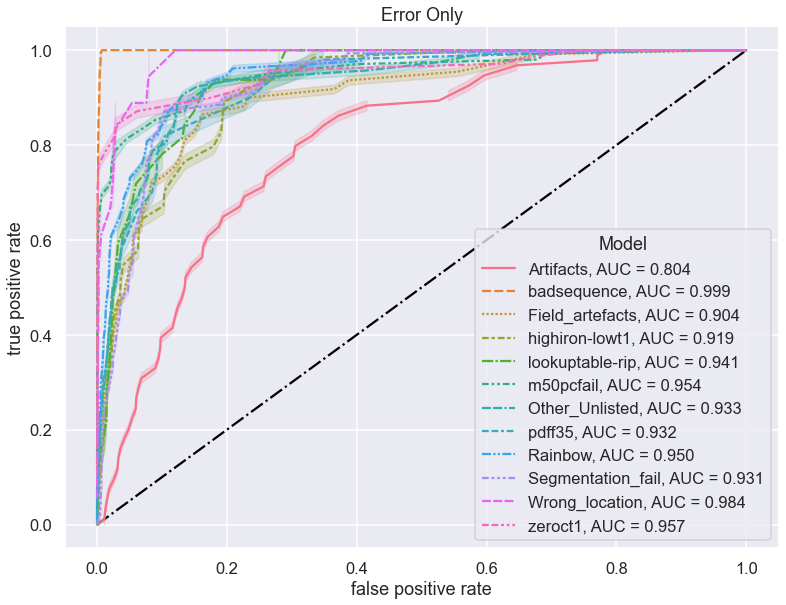

In [34]:
# Plot the ROC curves for each Class (One Vs Rest)
sns.set_theme(context="talk")
plt.figure()
plt.title("Error Only")
sns.lineplot(x=[0,1],y=[0,1],linestyle="-.",color='black')
sns.lineplot(data=df,x="false positive rate",y="true positive rate",hue="Model",style="Model")
plt.show()

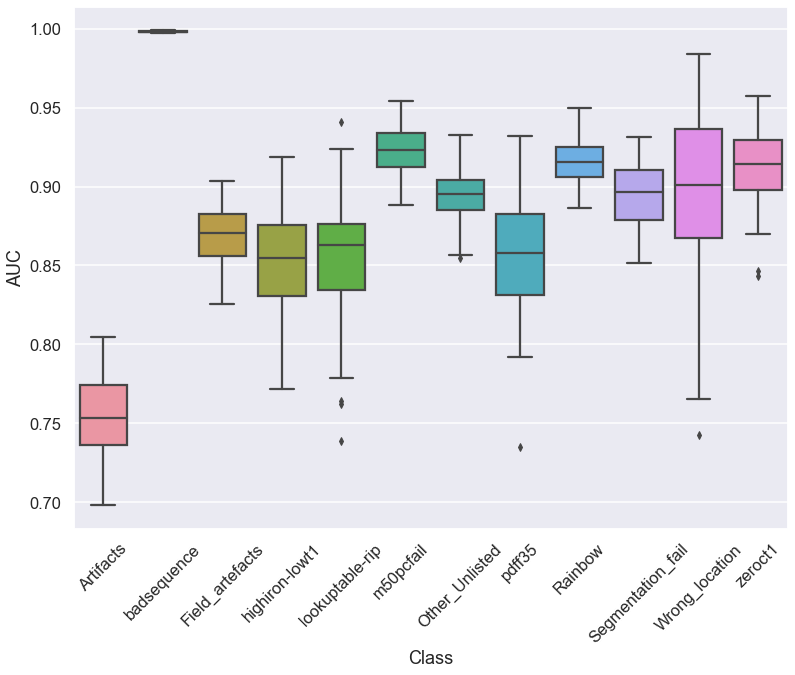

In [35]:
dictBox = {"Class":[],"AUC":[]}
for k in avgAUC.keys():
    for itm in avgAUC[k]:
        dictBox["Class"].append(k)
        dictBox["AUC"].append(itm)

dfBox = pandas.DataFrame(dictBox)

sns.boxplot(x="Class",y="AUC",data=dfBox)
plt.xticks(rotation=45)
plt.show()

In [36]:
# Save Models
saveDir = "./models/Random Forests/Error_Only/"

if not os.path.isdir(saveDir):
    os.mkdir(saveDir)

for name in tagNames:
    if not os.path.isdir(os.path.join(saveDir,name)):
        os.mkdir(os.path.join(saveDir,name))
    pickle.dump(clfDict[name], open(os.path.join(saveDir,name,"classifier.sav"),'wb'))

df2.to_excel(os.path.join(saveDir,"metrics.xlsx"))
df2.to_json(os.path.join(saveDir,"metrics.json"))

df.to_excel(os.path.join(saveDir,"roc_values.xlsx"))
df.to_json(os.path.join(saveDir,"roc_values.json"))

## Error + BBoxes:

In [37]:
x0, y0 = ownDataset

metricsDict = {}
clfDict = {}

topAUC = {}
avgAUC = {}
for name in tagNames:
    topAUC[name] = 0.0
    metricsDict[name] = {}
    avgAUC[name] = []
    clfDict[name] = {}

cnt = 0
for idx,name in enumerate(tagNames):

    y = y0[:,idx]
    X = x0[:,-(errLength+bBoxesLength):]

    rskf = RepeatedStratifiedKFold(random_state=42)

    for train_index, test_index in rskf.split(X, y):
        sys.stdout.write("\r[{}/{}]".format(cnt,5*10*len(tagNames)))

        clf = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,verbose=False,n_jobs=-1)

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        probs = clf.predict_proba(X_test)

        fpr,tpr,thresh = roc_curve(y_test,probs[:,1])
        auc_score = roc_auc_score(y_test,probs[:,1])

        avgAUC[name].append(auc_score)

        if topAUC[name] < auc_score:
            topAUC[name] = auc_score

            clfDict[name]["Classifier"] = clf
            clfDict[name]["X_train"] = X_train
            clfDict[name]["y_train"] = y_train
            clfDict[name]["X_test"] = X_test
            clfDict[name]["y_test"] = y_test

            metricsDict[name]["AUC"] = auc_score
            metricsDict[name]["FPR"] = fpr
            metricsDict[name]["TPR"] = tpr

        cnt +=1

[599/600]

In [40]:
# Format for Seaborn

modelsArr = []
fprArr = []
tprArr = []

for name in tagNames:
    auc_score = metricsDict[name]["AUC"]
    fpr = metricsDict[name]["FPR"]
    tpr = metricsDict[name]["TPR"]

    event = ["{}, AUC = {:.3f}".format(name,auc_score)]*(fpr.shape[0])

    modelsArr.extend(event)
    fprArr.extend(fpr)
    tprArr.extend(tpr)

event = np.array(modelsArr)
fpr = np.array(fprArr)
tpr = np.array(tprArr)

df = pandas.DataFrame({"Model":event,"false positive rate":fpr,"true positive rate":tpr})
df2 = pandas.DataFrame(avgAUC)
print(df2.describe())

print("#"*50)

tempDict = {"Name":tagNames,"Max AUC":[metricsDict[name]["AUC"] for name in tagNames],"Avg AUC":[np.mean(avgAUC[name]) for name in tagNames]}

df3 = pandas.DataFrame(tempDict)
print(df3)

       Artifacts  badsequence  Field_artefacts  highiron-lowt1  \
count  50.000000    50.000000        50.000000       50.000000   
mean    0.760446     0.998665         0.866369        0.852017   
std     0.025813     0.000391         0.018104        0.029972   
min     0.710371     0.997708         0.829367        0.782148   
25%     0.737200     0.998389         0.852121        0.836524   
50%     0.760655     0.998765         0.864881        0.855070   
75%     0.782088     0.998914         0.879051        0.869214   
max     0.808563     0.999287         0.900934        0.912510   

       lookuptable-rip  m50pcfail  Other_Unlisted     pdff35    Rainbow  \
count        50.000000  50.000000       50.000000  50.000000  50.000000   
mean          0.858399   0.927700        0.899944   0.857793   0.919509   
std           0.044634   0.014685        0.016370   0.042026   0.012721   
min           0.749890   0.887790        0.858314   0.778578   0.890868   
25%           0.833452   0.917

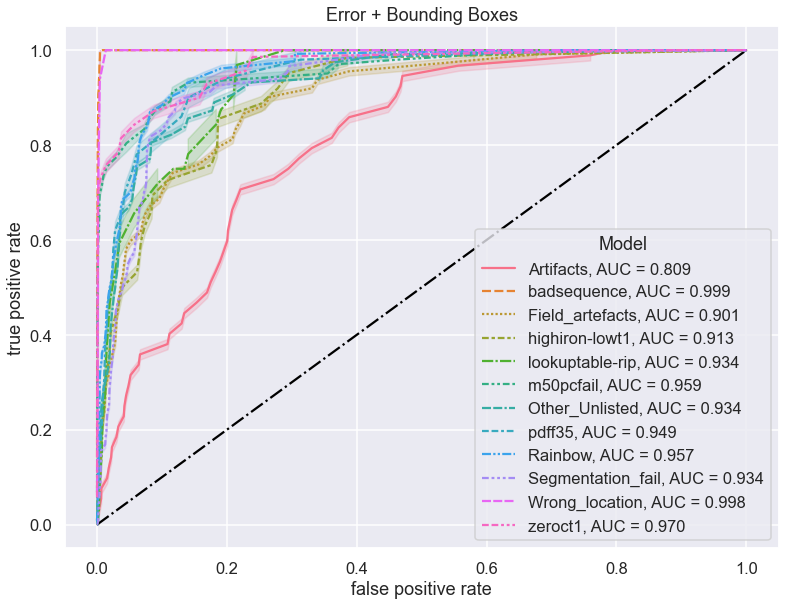

In [41]:
# Plot the ROC curves for each Class (One Vs Rest)
sns.set_theme(context="talk")

plt.figure()
plt.title("Error + Bounding Boxes")
sns.lineplot(x=[0,1],y=[0,1],linestyle="-.",color='black')
sns.lineplot(data=df,x="false positive rate",y="true positive rate",hue="Model",style="Model")
plt.show()

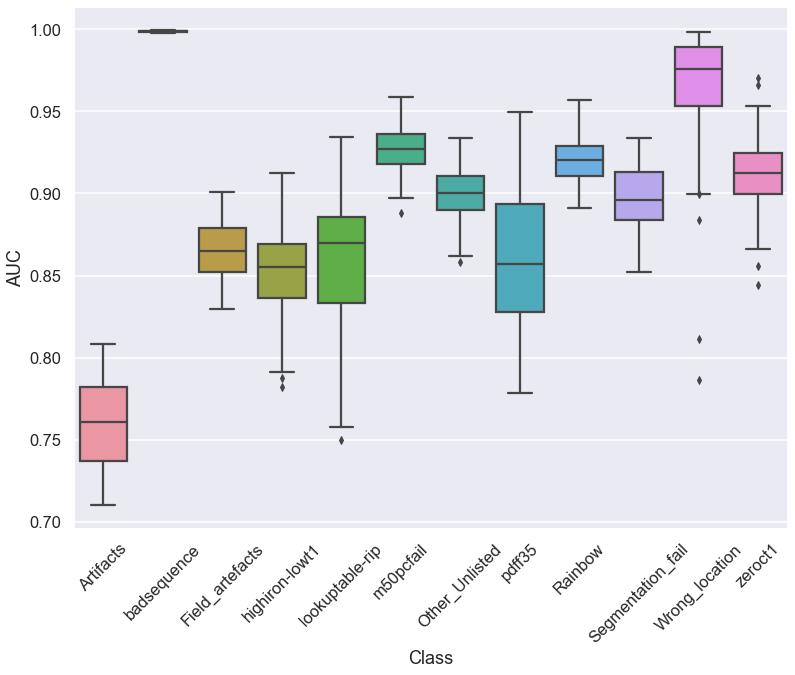

In [42]:
dictBox = {"Class":[],"AUC":[]}
for k in avgAUC.keys():
    for itm in avgAUC[k]:
        dictBox["Class"].append(k)
        dictBox["AUC"].append(itm)

dfBox = pandas.DataFrame(dictBox)

sns.boxplot(x="Class",y="AUC",data=dfBox)
plt.xticks(rotation=45)
plt.show()

In [43]:
# Save Models
saveDir = "./models/Random Forests/Error_BBoxes/"

if not os.path.isdir(saveDir):
    os.mkdir(saveDir)

for name in tagNames:
    if not os.path.isdir(os.path.join(saveDir,name)):
        os.mkdir(os.path.join(saveDir,name))
    pickle.dump(clfDict[name], open(os.path.join(saveDir,name,"classifier.sav"),'wb'))

df2.to_excel(os.path.join(saveDir,"metrics.xlsx"))
df2.to_json(os.path.join(saveDir,"metrics.json"))

df.to_excel(os.path.join(saveDir,"roc_values.xlsx"))
df.to_json(os.path.join(saveDir,"roc_values.json"))

# AUC Comparisons:

Error_Only
All_Meta
Error_BBoxes
Meta_Only
Meta_BBoxes


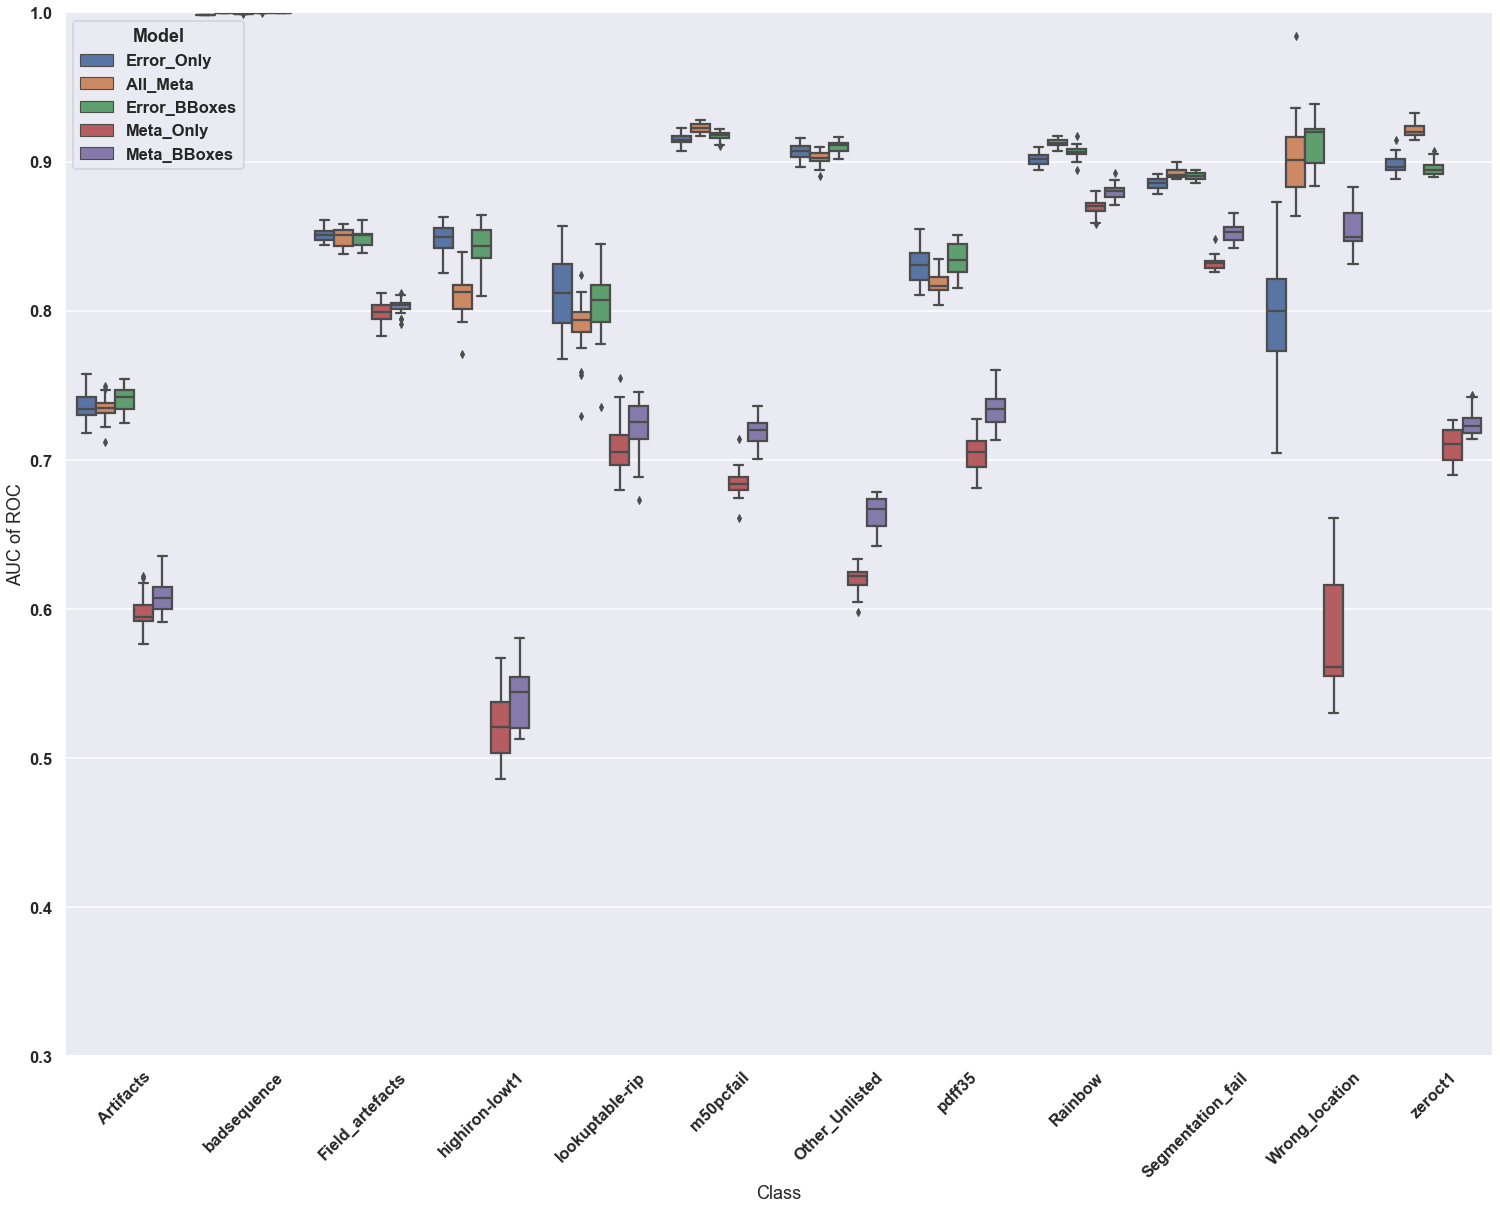

In [5]:
import seaborn as sns
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}

mpl.rc('font', **font)

plt.rcParams["figure.figsize"] = [6.4*4,4.8*4]
sns.set_theme("talk")
sns.set_style("darkgrid")

loadDir = "./models/Random Forests_KEEP/"
tagNames = ['Artifacts', 'badsequence', 'Field_artefacts', 'highiron-lowt1', 'lookuptable-rip', 'm50pcfail', 'Other_Unlisted', 'pdff35', 'Rainbow', 'Segmentation_fail', 'Wrong_location', 'zeroct1']

ignoreList = ["Float","Float_Categorical"]
rfList = [x for x in os.listdir(loadDir) if x not in ignoreList]

classList = []
aucList = []
modelList = []

for fol in rfList:
    print(fol)

    with open(os.path.join(loadDir,fol,"metrics.json")) as f:
        metrics = json.load(f)

    for k in tagNames:
        metricsClass = metrics[k]
        for k1 in metricsClass.keys():
            aucList.append(metricsClass[k1])
            classList.append(k)
            modelList.append(fol)

fullDict = {"Model":modelList,"Class":classList,"AUC":aucList}
df = pd.DataFrame(fullDict)

plt.figure()
sns.boxplot(data=df,x="Class",y="AUC",hue="Model")
plt.xlabel("Class")
plt.ylabel("AUC of ROC")
plt.ylim((0.3,1.0))
plt.xticks(rotation=45)
plt.show()

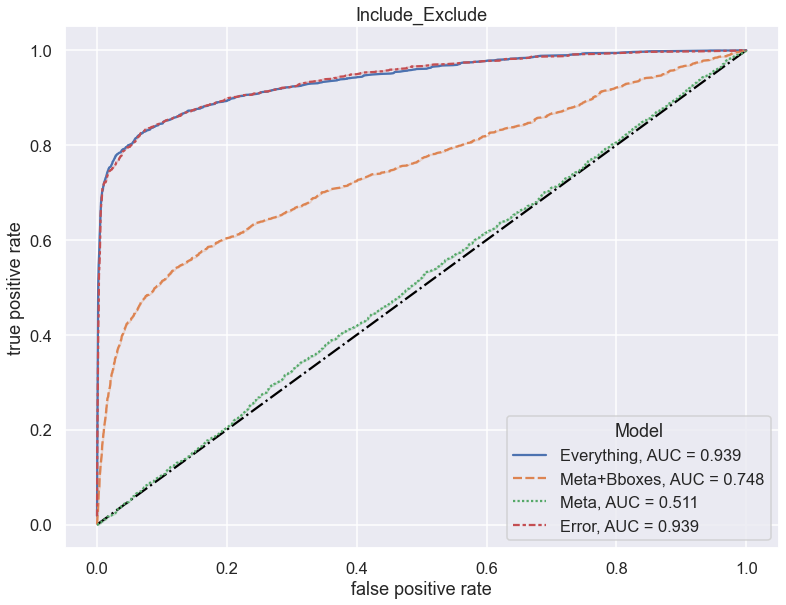

In [45]:
x0, y0 = ownDataset

newY = np.zeros(y0.shape[0])
for i in range(y0.shape[0]):
    if np.sum(y0[i,:]) >= 1:
        newY[i] = 1

y0 = newY

modelsArr = []
fprArr = []
tprArr = []
clfDict = {}

names = ["Everything","Meta+Bboxes","Meta","Error"]
features = [(0,-1),(0,-errFlat.shape[1]),(0,-(16+errFlat.shape[1])),(-errFlat.shape[1],-1)]

for name,(m,n) in zip(names,features):
    clf = RandomForestClassifier(n_estimators=100,max_depth=10,verbose=False,n_jobs=-1)

    y = y0
    if n == -1:
        X = x0[:,m:]
    else:
        X = x0[:,m:n]

    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.4,random_state=42)

    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    probs = clf.predict_proba(X_test)

    fpr,tpr,thresh = roc_curve(y_test,probs[:,1])
    auc_score = roc_auc_score(y_test,probs[:,1])

    event = ["{}, AUC = {:.3f}".format(name,auc_score)]*(fpr.shape[0])

    clfDict[name] = clf

    modelsArr.extend(event)
    fprArr.extend(fpr)
    tprArr.extend(tpr)

event = np.array(modelsArr)
fpr = np.array(fprArr)
tpr = np.array(tprArr)

df = pandas.DataFrame({"Model":event,"false positive rate":fpr,"true positive rate":tpr})

plt.figure()
plt.title("Include_Exclude")
sns.lineplot(x=[0,1],y=[0,1],linestyle="-.",color='black')
sns.lineplot(data=df,x="false positive rate",y="true positive rate",hue="Model",style="Model")
plt.show()

# Feature Importance:

In [37]:

featuresPlot = {}
for name in tagNames:
    featuresPlot[name] = []

for idx,name in enumerate(tagNames):
    print("#"*50)
    print(name)
    print("#"*50)

    clf = clfDict[name]
    instCnt = 0
    featCnt = -1
    for i,fImp in enumerate(clf.feature_importances_):
        if i % 7 == 0:
            instCnt = 0
            featCnt += 1
        if fImp > 0.005:
            featuresPlot[name].append((keysOI[featCnt],instTime[instCnt]))
            print("{},\t {}, \t\t\t {}".format(keysOI[featCnt],instTime[instCnt],fImp))
        instCnt += 1
    print("#"*50)


##################################################
Artifacts
##################################################


KeyError: 'Artifacts'

In [ ]:
name = "Segmentation_fail"

features = [x[0] for x in featuresPlot['Artifacts']]
features = list(set(features))

for topFeature in features:
    metaList = []
    instTimeList = []
    tagListStr = []
    for i,k in enumerate(metaDict.keys()):
        for inst in instTime:
            instTimeList.append(inst)
            metaList.append(metaDict[k][inst][topFeature])
            if k in tagDict.keys():
                issues = tagDict[k]
                if issues[idx] == 1:
                    tagListStr.append("Exclude")
                else:
                    tagListStr.append("Include")
            else:
                tagListStr.append("Include")

    d = {topFeature:metaList,"Instance":instTimeList,"Class":tagListStr}
    df = pandas.DataFrame(data=d)

    sns.violinplot(x="Instance",y=topFeature,hue="Class",split=False,data=df)
    plt.show()


## Start from here to load and plot ROC curves

Error_Only


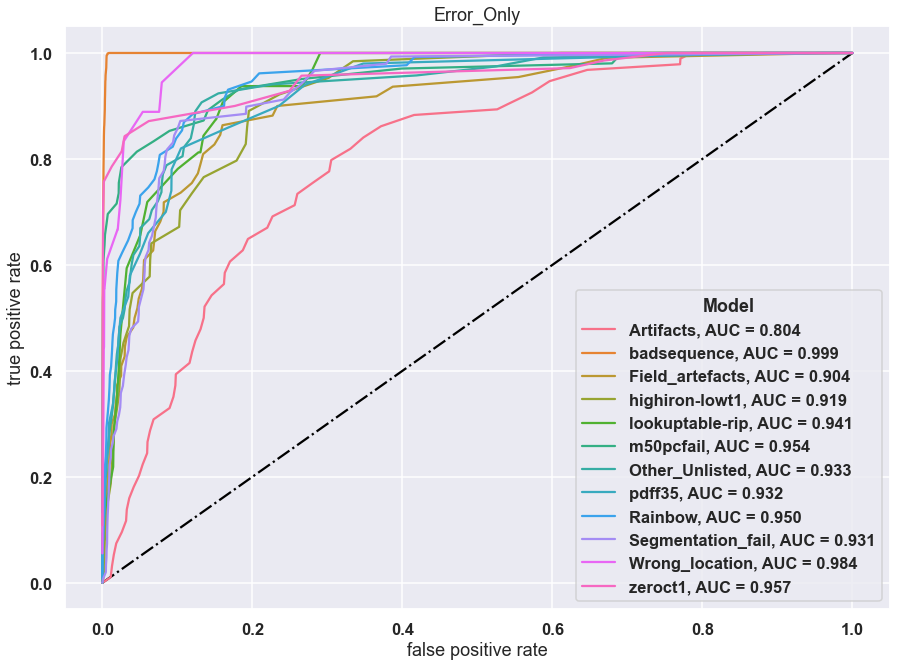

All_Meta


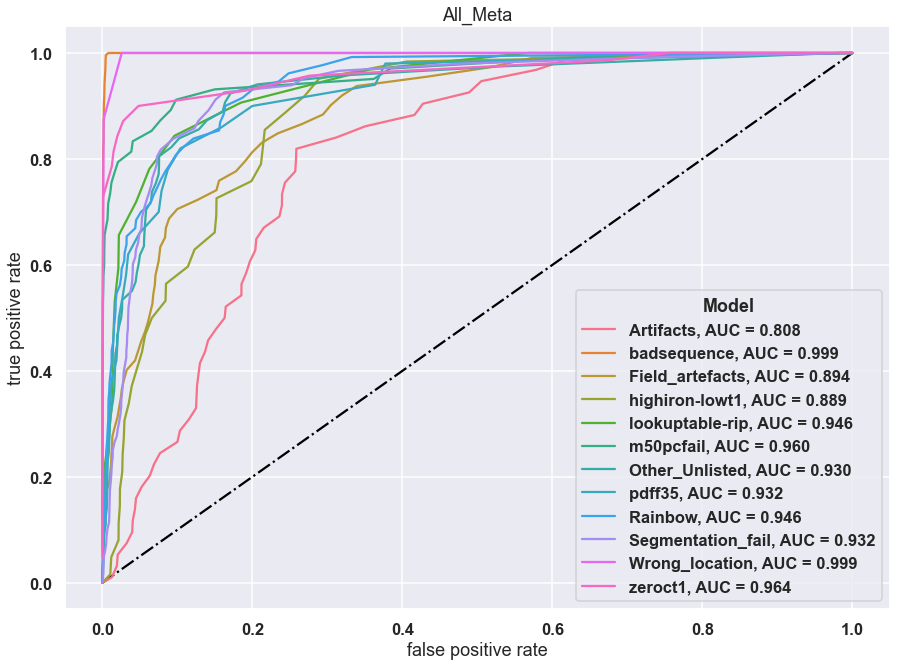

Error_BBoxes


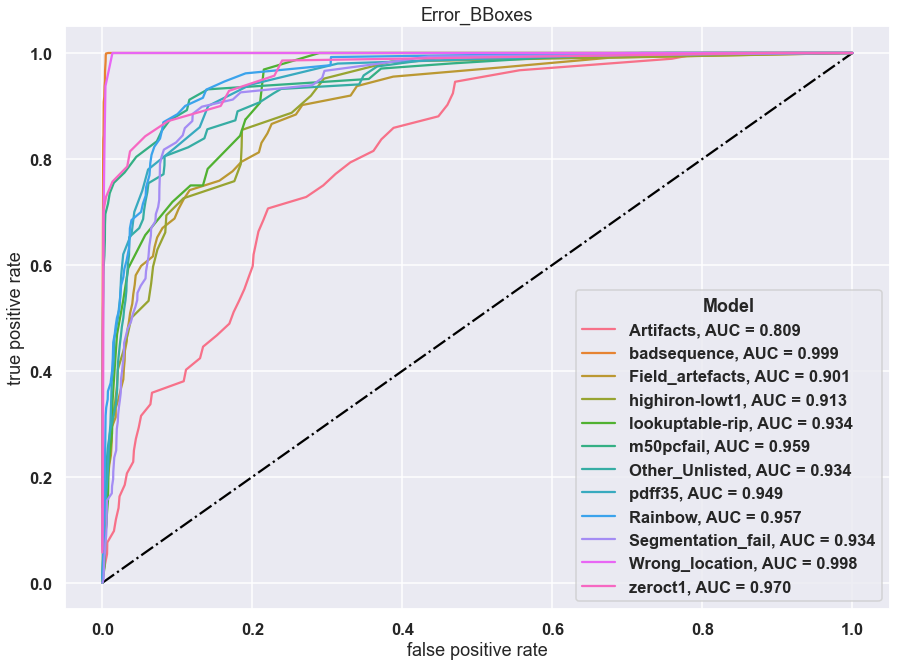

Meta_Only


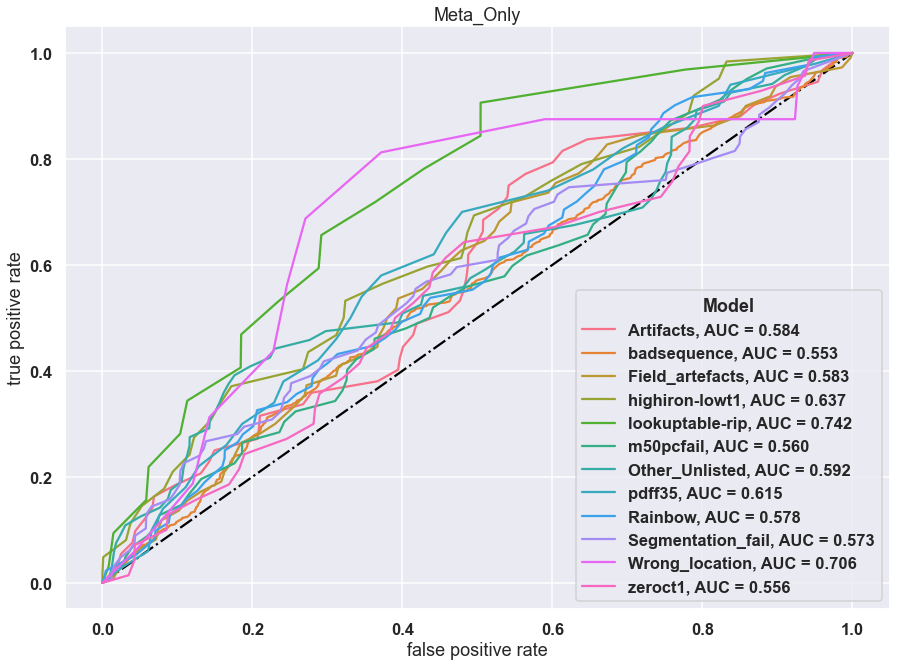

Meta_BBoxes


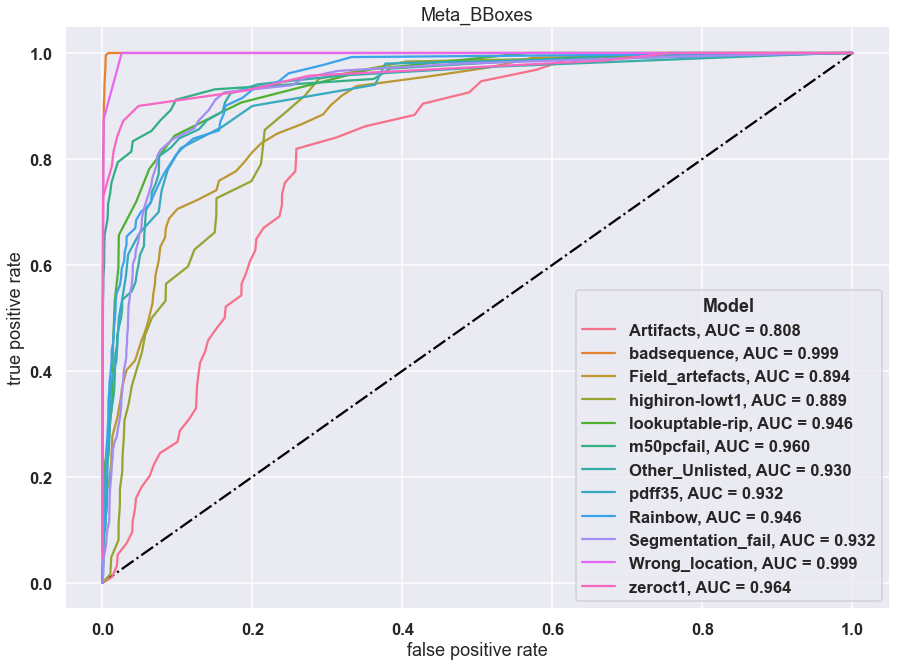

In [7]:
import seaborn as sns
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}

mpl.rc('font', **font)

plt.rcParams["figure.figsize"] = [6.4*2,4.8*2]
sns.set_theme("talk")
sns.set_style("darkgrid")

loadDir = "./models/Random Forests/"
tagNames = ['Artifacts', 'badsequence', 'Field_artefacts', 'highiron-lowt1', 'lookuptable-rip', 'm50pcfail', 'Other_Unlisted', 'pdff35', 'Rainbow', 'Segmentation_fail', 'Wrong_location', 'zeroct1']

ignoreList = ["Float","Float_Categorical"]
rfList = [x for x in os.listdir(loadDir) if x not in ignoreList]


for fol in rfList:
        print(fol)
        with open(os.path.join(loadDir,fol,"roc_values.json")) as f:
                df = pd.read_json(f)


        sns.set_theme(context="talk")
        sns.set_style("darkgrid")
        plt.figure()
        plt.title(fol)
        sns.lineplot(x=[0,1],y=[0,1],linestyle="-.",color='black')
        sns.lineplot(data=df,x="false positive rate",y="true positive rate",hue="Model",style="Model",ci=None)
        plt.tight_layout()
        plt.savefig("./Figures/ROC_RF_{}.png".format(fol))
        plt.show()

In [11]:
import pickle

for fol in rfList:
    print(fol)
    saveDir = "./models/Random Forests/{}/".format(fol)

    for i,name in enumerate(tagNames):

        clfDict = pickle.load(open(os.path.join(saveDir,name,"classifier.sav"),'wb'))

        clf = clfDict[name]["Classifier"]
        X_test = clfDict[name]["X_test"]
        y_test = clfDict[name]["y_test"]

        pred = clf(X_test)
        print(pred)
        break

        fprDict[name], tprDict[name], _ = roc_curve(y_test[:,i],pred[:,i])
        rocDict[name] = roc_auc_score(y_test[:,i],pred[:,i])
    break

    fprDict = {}
    tprDict = {}
    rocDict = {}


    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fprDict[name] for name in tagNames]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for name in tagNames:
        mean_tpr += np.interp(all_fpr, fprDict[name], tprDict[name])

    # Finally average it and compute AUC
    mean_tpr /= len(tagNames)
    auc_score = auc(all_fpr,mean_tpr)
    event = ["{}, AUC = {:.3f}".format("macro avg.",auc_score)]*(all_fpr.shape[0])

    modelsArr.extend(event)
    fprArr.extend(all_fpr)
    tprArr.extend(mean_tpr)

    fpr,tpr,_ = roc_curve(y_test.ravel(),pred.ravel())
    auc_score = roc_auc_score(y_test.ravel(),pred.ravel())

    event = ["{}, AUC = {:.3f}".format("micro avg.",auc_score)]*(fpr.shape[0])

    modelsArr.extend(event)
    fprArr.extend(fpr)
    tprArr.extend(tpr)

    event = np.array(modelsArr)
    fpr = np.array(fprArr)
    tpr = np.array(tprArr)
    df = pandas.DataFrame({"Model":event,"false positive rate":fpr,"true positive rate":tpr})

    plt.figure()
    plt.title("VGG")
    sns.lineplot(x=[0,1],y=[0,1],linestyle="-.",color='black')
    sns.lineplot(data=df,x="false positive rate",y="true positive rate",hue="Model",style="Model",ci=None)
    plt.show()

Error_Only


FileNotFoundError: [Errno 2] No such file or directory: './models/Random Forests/Error_Only/Artifacts/classifier.sav'